# Email Spam Detection
<!--
*** I'm using markdown "reference style" links for readability.
*** Reference links are enclosed in brackets [ ] instead of parentheses ( ).
*** See the bottom of this document for the declaration of the reference variables
*** This documentation will be finished when this projects finishes.
-->
1. #### Importing libraries
        this are necessary libraries
            - pandas
            - numpy
            - scikit-learn.preprocessing (LabelEncoder)

In [2]:
import gensim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pylab as plt
import nltk
import seaborn as sns

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

2. #### Collection of Data
        I use public datasets:
            - Email-Spam-Classification-dataset-csv
            - Enron Email Dataset
            - deceptive-opinion-spam-corpus
            - spam-or-not-spam-dataset
            - spam-email
            - sms-spam-collection-dataset
            - email-spam-dataset
            - email-spam-classification-dataset-csv
        format: Each row is in text (message/email) and label (spam/ham).

In [3]:
complete_spam = pd.read_csv("dataset/completeSpamAssassin.csv", index_col=0)
null_rows = complete_spam[complete_spam.isnull().any(axis=1)]
complete_spam = complete_spam.dropna()
complete_spam.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
complete_spam.head()

,message,label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [4]:
enron = pd.read_csv("dataset/enronSpamSubset.csv", index_col=0)
enron = enron.drop(columns=["Unnamed: 0"])
enron.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
enron.head()

,message,label
2469,Subject: stock promo mover : cwtd\n * * * urge...,1
5063,Subject: are you listed in major search engine...,1
12564,"Subject: important information thu , 30 jun 20...",1
2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
1468,"Subject: "" bidstogo "" is places to go , things...",1


In [5]:
ling_spam = pd.read_csv("dataset/lingSpam.csv", index_col=0)
ling_spam.rename(columns={"Body": "message", "Label":'label'}, inplace=True)
ling_spam.head()

,message,label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


In [6]:
deceptive = pd.read_csv("dataset/deceptive-opinion.csv")
deceptive = deceptive.iloc[:, [2, 4]]
label = pd.get_dummies(deceptive['polarity'], drop_first=True)
deceptive.drop(columns=['polarity'], inplace=True)
new_deceptive = pd.concat([deceptive, label], axis=1)
new_deceptive.rename(columns={"text": "message", "positive":'label'}, inplace=True)
new_deceptive.head()

,message,label
0,We stayed for a one night getaway with family ...,True
1,Triple A rate with upgrade to view room was le...,True
2,This comes a little late as I'm finally catchi...,True
3,The Omni Chicago really delivers on all fronts...,True
4,I asked for a high floor away from the elevato...,True


In [7]:
spam = pd.read_csv("dataset/spam_or_not_spam.csv")
spam.rename(columns={'email': 'message'}, inplace=True)
spam.head()

,message,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


##### Shape of Dataset

In [8]:
print(f"dataset 1 : {complete_spam.shape}")
print(f"dataset 2 : {spam.shape}")
print(f"dataset 3 : {new_deceptive.shape}")
print(f"dataset 4 : {ling_spam.shape}")
print(f"dataset 5 : {enron.shape}")
print(f"total expected shape : ({complete_spam.shape[0] + spam.shape[0] + new_deceptive.shape[0] + ling_spam.shape[0] + enron.shape[0]}, 2)")

dataset 1 : (6045, 2)
dataset 2 : (3000, 2)
dataset 3 : (1600, 2)
dataset 4 : (2605, 2)
dataset 5 : (10000, 2)
total expected shape : (23250, 2)


In [9]:
dfs = [complete_spam, spam, new_deceptive, ling_spam, enron]
spam_dataset = pd.concat(dfs, axis=0, ignore_index=True)
spam_dataset.tail()
print(spam_dataset.shape)

(23250, 2)


##### Checking Missing Values

In [10]:
spam_dataset.isnull().sum()

message    1
label      0
dtype: int64

##### Checking Duplicate Values

In [11]:
spam_dataset.duplicated().sum()

1210

##### Remove Duplicate Values

In [18]:
spam_dataset = spam_dataset.dropna()
spam_dataset = spam_dataset.drop_duplicates(keep='first')
spam_dataset = spam_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
spam_dataset.head()

,message,label
0,Subject: fw : computers\n happy holidays !\n b...,0
1,Subject: requested\n \n increase your personal...,1
2,"Subject: budget review ii\n hi louise ,\n are ...",0
3,"URL: http://www.newsisfree.com/click/-1,839012...",0
4,I stayed at the Fairmont during a professional...,1


##### Final Shape of Dataset

In [19]:
print(f"After removing duplicate values. The final shape of dataset : {spam_dataset.shape}")

After removing duplicate values. The final shape of dataset : (22039, 2)


3. #### EDA aka Exploratory Data Analysis
        The goal is to investigating data, understanding patterns, checking (anomalies, outliers), summarize key structure before applying any types of machine learning or statistical models.


In [21]:
values = spam_dataset['label'].value_counts()
total = values[0] + values[1]

percentage_0 = (values[0] / total) * 100
percentage_1 = (values[1] / total) * 100

print(f"Percentage of target (ham) : {percentage_0}")
print(f"Percentage of target (spam) : {percentage_1}")

Percentage of target (ham) : 64.6626434956214
Percentage of target (spam) : 35.337356504378604


#### Pie Chart (Email Classification)

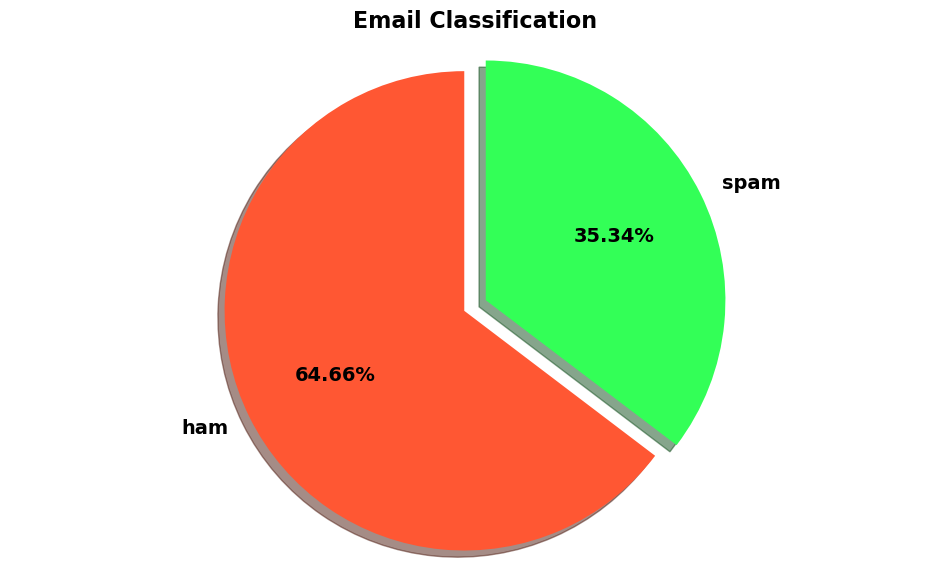

In [22]:
plt.figure(figsize=(12, 7)) # i know i 'm taking huge figure but i like that

colors = ['#FF5733', '#33FF57'] # red-oraney and green are my colors
myexplode = [0, 0.1]    # define explode parameter to create a gap between slices by 10%
mylabels = ['ham', 'spam']  # ham and spam are categories


plt.pie(
    values,
    startangle=90,  # set angle
    autopct='%0.2f%%',  # add percentage value
    labels=mylabels, # labeling pie with ham and spam
    explode=myexplode, # explode ham with 10%
    colors=colors,  # add your colors
    shadow=True, # add shadow
    textprops={'fontsize': 14, 'fontweight': 'bold'}    # add fontsize and weight
    )

plt.axis('equal')   #set axis equal so that pie looks circle
plt.title("Email Classification", fontweight="bold", fontsize=16)
plt.show()

#### Summary for Text, Chars, Sentences Length

In [23]:
import re
def count_characters(text):
    words = re.findall(r'[a-zA-Z]', text)
    icount = 0
    for w in words:
        if w.isdigit():
            continue
        icount = icount + 1
    return icount

In [24]:
spam_dataset['num_characters'] = spam_dataset['message'].apply(count_characters)
spam_dataset['num_words'] = spam_dataset['message'].apply(lambda x: len(nltk.word_tokenize(x)))
spam_dataset['num_sentences'] = spam_dataset['message'].apply(lambda x: len(nltk.sent_tokenize(x)))

spam_dataset[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,2.203900e+04,2.203900e+04,22039.000000
mean,1.823136e+03,5.119527e+02,27.475430
std,8.046392e+04,2.441711e+04,1504.483484
min,0.000000e+00,0.000000e+00,0.000000
25%,3.170000e+02,8.800000e+01,3.000000
50%,6.200000e+02,1.740000e+02,8.000000
75%,1.244000e+03,3.480000e+02,16.000000
max,1.193657e+07,3.623500e+06,223247.000000


##### Summary Statistics for the legitimate message (emails)

In [25]:
spam_dataset[spam_dataset['label'] == 0 ][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,1.425100e+04,14251.000000,1.425100e+04
mean,2.164088e+03,32.329872,6.163865e+02
std,1.000321e+05,1870.577373,3.036105e+04
min,3.000000e+00,1.000000,1.000000e+00
25%,3.310000e+02,3.000000,9.200000e+01
50%,6.770000e+02,7.000000,1.890000e+02
75%,1.312000e+03,15.000000,3.700000e+02
max,1.193657e+07,223247.000000,3.623500e+06


##### Summary Statistics for the spam messages (email)

In [26]:
spam_dataset[spam_dataset['label'] == 1][['num_characters', 'num_sentences', 'num_words']].describe()

,num_characters,num_sentences,num_words
count,7788.000000,7788.000000,7788.000000
mean,1199.238701,18.592450,320.852851
std,3354.267335,50.441562,615.707086
min,0.000000,0.000000,0.000000
25%,298.000000,5.000000,84.000000
50%,533.000000,9.000000,150.000000
75%,1084.000000,18.000000,300.000000
max,195468.000000,3093.000000,13292.000000


In [27]:
spam_dataset[['label', 'num_characters', 'num_sentences', 'num_words']].corr()

,label,num_characters,num_sentences,num_words
label,1.000000,-0.005732,-0.004365,-0.005786
num_characters,-0.005732,1.000000,0.999390,0.999802
num_sentences,-0.004365,0.999390,1.000000,0.999733
num_words,-0.005786,0.999802,0.999733,1.000000


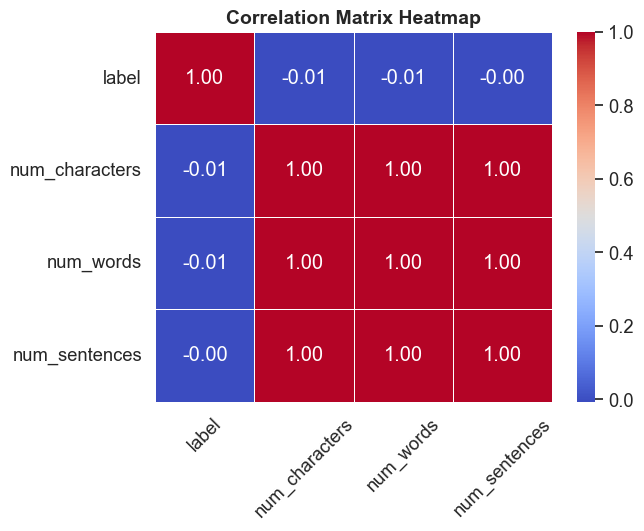

In [28]:
corr_matrix = spam_dataset[['label', 'num_characters', 'num_words', 'num_sentences']].corr()

sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, fmt='0.2f', linewidths=0.5, cmap='coolwarm')

plt.title('Correlation Matrix Heatmap', fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.show()

#### Data Text Preprocessing
        Before data preprocessing let's understand how the spam are introduce in the mail and what type of the spam can be added in the email.

In [29]:
def custom_tokenizer(text):

    tokens = []

    # replace URLs with tokens
    url_pattern = r'(?:https?\s?:\/\/?|http\s?:\/\/?|https\s?\/\/|http\s?\/\/|www\.)[^\s<>"{}|\\^`\[\]]+'
    urls = re.findall(url_pattern, text)
    text = re.sub(url_pattern, ' URL_TOKEN ', text)
    tokens.extend(['URL_TOKEN'] * len(urls))  # if more than two url then

    # Replace emails with tokens
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    emails = re.findall(email_pattern, text)
    text = re.sub(email_pattern, ' EMAIL_TOKEN ', text)
    tokens.extend(['EMAIL_TOKEN'] * len(emails))

    # replace phone numbers
    phone_pattern = r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b'
    phones = re.findall(phone_pattern, text)
    text = re.sub(phone_pattern, ' PHONE_TOKEN ', text)
    tokens.extend(['PHONE_TOKEN'] * len(phones))

    # replace currency
    currency_pattern =  r'\$\d+(?:\.\d{2})?'
    currency = re.findall(currency_pattern, text)
    text = re.sub(currency_pattern, ' MONEY_TOKEN ', text)
    tokens.extend(['MONEY_TOKEN'] * len(currency))

    # replace numbers
    number_pattern = r'\b\d+(?:\.\d+)?\b'
    numbers = re.findall(number_pattern, text)
    text = re.sub(number_pattern, ' NUM_TOKEN ', text)
    tokens.extend(['NUM_TOKEN'] * len(numbers))

    # remove _____ spaces
    text = re.sub(r'[_]{3,}', ' ', text)

    # tokenizing common words
    word_pattern = r'\b[A-Za-z]+\b'
    words = re.findall(word_pattern, text.lower())
    tokens.extend(words)

    return text, tokens

text = """Visit https://example.com for more info
        Contact us at support@company.com or call 555-0123
        The price is $29.99 for 10 items
        Check out www.github.com and email me at user@domain.org
        Regular text without special patterns"""

text, tokens = custom_tokenizer(text)
print(tokens)
print(text)

['URL_TOKEN', 'URL_TOKEN', 'EMAIL_TOKEN', 'EMAIL_TOKEN', 'MONEY_TOKEN', 'NUM_TOKEN', 'NUM_TOKEN', 'NUM_TOKEN', 'visit', 'for', 'more', 'info', 'contact', 'us', 'at', 'or', 'call', 'the', 'price', 'is', 'for', 'items', 'check', 'out', 'and', 'email', 'me', 'at', 'regular', 'text', 'without', 'special', 'patterns']
Visit  URL_TOKEN  for more info
        Contact us at  EMAIL_TOKEN  or call  NUM_TOKEN - NUM_TOKEN 
        The price is  MONEY_TOKEN  for  NUM_TOKEN  items
        Check out  URL_TOKEN  and email me at  EMAIL_TOKEN 
        Regular text without special patterns


In [30]:
def text_representation(text):

    # tokenize the word
    tokens = word_tokenize(text)

    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(tokens)
    feature_names = tfidf.get_feature_names_out()

    print("TF IDF Vectorizer: ")
    print(f"matrix : {tfidf_matrix}")
    print(f"features : {feature_names}")

text_representation(text)

TF IDF Vectorizer: 
matrix :   (0, 25)	1.0
  (1, 23)	1.0
  (2, 7)	1.0
  (3, 13)	1.0
  (4, 8)	1.0
  (5, 4)	1.0
  (6, 24)	1.0
  (7, 1)	1.0
  (8, 6)	1.0
  (9, 15)	1.0
  (10, 2)	1.0
  (11, 14)	1.0
  (13, 14)	1.0
  (14, 22)	1.0
  (15, 18)	1.0
  (16, 9)	1.0
  (17, 12)	1.0
  (18, 7)	1.0
  (19, 14)	1.0
  (20, 10)	1.0
  (21, 3)	1.0
  (22, 16)	1.0
  (23, 23)	1.0
  (24, 0)	1.0
  (25, 5)	1.0
  (26, 11)	1.0
  (27, 1)	1.0
  (28, 6)	1.0
  (29, 19)	1.0
  (30, 21)	1.0
  (31, 26)	1.0
  (32, 20)	1.0
  (33, 17)	1.0
features : ['and' 'at' 'call' 'check' 'contact' 'email' 'email_token' 'for' 'info'
 'is' 'items' 'me' 'money_token' 'more' 'num_token' 'or' 'out' 'patterns'
 'price' 'regular' 'special' 'text' 'the' 'url_token' 'us' 'visit'
 'without']


In [31]:

def get_wordnet_pos(tag):
    """Map POS tag to WordNet POS tag for better lemmatization"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to noun

def text_preprocessing(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # lowercase
    text = text.lower().strip()

    # clean weird punctuation (like ... or ----)
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'-{2,}', ' ', text)

    # tokenize
    words = word_tokenize(text)

    # remove punctuation & empty tokens
    words = [w for w in words if w not in string.punctuation and w.strip() != '']

    # POS tagging
    tokens = pos_tag(words)

    lemmatized_sentence = []
    for word, pos in tokens:
        wn_pos = get_wordnet_pos(pos)  # better lemmatization
        lemma = lemmatizer.lemmatize(word, wn_pos)

        if (word not in stop_words):
            lemmatized_sentence.append(lemma)

    lemm_sent = ' '.join(lemmatized_sentence)

    # final pass with custom tokenizer
    text, tokens = custom_tokenizer(lemm_sent)

    return text

text = """
Subject: 🎉 CONGRATULATIONS! You've Won $1,000,000! 🎉
From: winner-notification@lottery-international.biz
Body:
DEAR LUCKY WINNER!!!
CONGRATULATIONS! You have been selected as the GRAND PRIZE WINNER of our International Email Lottery! Your email address was randomly selected from millions of addresses worldwide.
YOU HAVE WON: $1,000,000 USD!!!
To claim your prize, you MUST respond within 24 HOURS with the following information:

Full Name
Address
Phone Number
Bank Account Details
Copy of ID/Passport

URGENT: Send processing fee of $500 via Western Union to claim your winnings immediately!
Contact our claims agent: Mr. Johnson Smith
Email: claims.agent.smith@totally-legit-lottery.com
Phone: +234-555-7845
This offer expires TOMORROW! Don't miss this once-in-a-lifetime opportunity!
Best Regards,
International Lottery Commission
"""
processed_tokens = text_preprocessing(text)
print(processed_tokens)

subject 🎉 congratulation 've  NUM_TOKEN , NUM_TOKEN , NUM_TOKEN  🎉 winner-notification lottery-international.biz body dear lucky winner congratulation select grand prize winner international email lottery email address randomly select million address worldwide  NUM_TOKEN , NUM_TOKEN , NUM_TOKEN  usd claim prize must respond within  NUM_TOKEN  hour follow information full name address phone number bank account detail copy id/passport urgent send process fee  NUM_TOKEN  via western union claim winning immediately contact claim agent mr. johnson smith email claims.agent.smith totally-legit-lottery.com phone + PHONE_TOKEN  offer expire tomorrow n't miss once-in-a-lifetime opportunity best regard international lottery commission


In [32]:
spam_dataset['cleaned_message'] = spam_dataset['message'].apply(text_preprocessing)
spam_dataset.head()

,message,label,num_characters,num_words,num_sentences,cleaned_message
0,Subject: fw : computers\n happy holidays !\n b...,0,1090,438,45,subject fw computer happy holiday bonnie hitsc...
1,Subject: requested\n \n increase your personal...,1,341,85,6,subject request increase personal prestige mon...
2,"Subject: budget review ii\n hi louise ,\n are ...",0,185,52,3,subject budget review ii hi louise ok u come s...
3,"URL: http://www.newsisfree.com/click/-1,839012...",0,78,21,1,url URL_TOKEN date NUM_TOKEN - NUM_TOKEN -3...
4,I stayed at the Fairmont during a professional...,1,320,74,4,stay fairmont professional conference say conf...


In [51]:
spam_dataset['cleaned_message'][0]

'subject fw computer happy holiday bonnie hitschel  NUM_TOKEN   NUM_TOKEN   NUM_TOKEN  subject computer dear tech support last year upgrade boyfriend  NUM_TOKEN   NUM_TOKEN  husband  NUM_TOKEN   NUM_TOKEN  notice slowdown performance flower jewelry application operate flawlessly boyfriend  NUM_TOKEN   NUM_TOKEN  addition husband  NUM_TOKEN   NUM_TOKEN  uninstalled many valuable program romance  NUM_TOKEN   NUM_TOKEN  instal undesirable program nfl  NUM_TOKEN   NUM_TOKEN  nba  NUM_TOKEN   NUM_TOKEN  conversation  NUM_TOKEN   NUM_TOKEN  long run houseclean  NUM_TOKEN   NUM_TOKEN  simply crash system try run nag  NUM_TOKEN   NUM_TOKEN  fix problem avail desperate dear desperate first keep mind boyfriend  NUM_TOKEN   NUM_TOKEN  entertainment package husband  NUM_TOKEN   NUM_TOKEN  operating system install tear  NUM_TOKEN   NUM_TOKEN  enter command husband  NUM_TOKEN   NUM_TOKEN  automatically run application guilty  NUM_TOKEN   NUM_TOKEN  flower  NUM_TOKEN   NUM_TOKEN  remember overuse cau

In [33]:
# calculating the length of the cleaned message
spam_dataset['cleaned_message'].apply(lambda x: len(x.split(" ")))

0        291
1         49
2         27
3         23
4         34
        ... 
22034     22
22035    129
22036     60
22037    162
22038     32
Name: cleaned_message, Length: 22039, dtype: int64

In [34]:
print(f"length of the cleaned preprocessed message : {len(spam_dataset['cleaned_message'])}")

length of the cleaned preprocessed message : 22039


### Tokenizing and Embedding 

In [35]:
default_tokenizer = Tokenizer()
default_tokenizer.fit_on_texts(spam_dataset['cleaned_message'])
word_index = default_tokenizer.word_index
vocab_size = len(word_index) + 1
print(vocab_size)

146471


In [36]:
sent_length = 500
sequences = default_tokenizer.texts_to_sequences(spam_dataset['cleaned_message'])
padding = pad_sequences(sequences, padding='post', maxlen=sent_length)
print(padding)

[[    5  1263   135 ...     0     0     0]
 [    5   201   410 ...     0     0     0]
 [    5  1783   196 ...     0     0     0]
 ...
 [    5    55 15561 ...     0     0     0]
 [    5  1263  3024 ...     0     0     0]
 [    5    15  4109 ...     0     0     0]]


In [37]:
print(f"length of the tokenized documents : {len(word_index) + 1}")

length of the tokenized documents : 146471


In [38]:
print(f"length of the labeled columns : {len(spam_dataset['label'])}")

length of the labeled columns : 22039


#### Splitting the Dataset into the Training and Testing Set

In [39]:
X_train, X_test, y_train, y_test = train_test_split(padding, spam_dataset['label'], test_size=0.2, random_state=42)

In [40]:
X_train[:10]

array([[    12,    247,    324, ...,    645,    401,    934],
       [   300,     45,    540, ...,      0,      0,      0],
       [141259, 141260,    449, ...,   1073,    164,    408],
       ...,
       [   662,     22,   1369, ...,      0,      0,      0],
       [   870,    445,    119, ...,      0,      0,      0],
       [   191,  41669,   3570, ...,    511,    857,   2390]])

In [41]:
# shapes of the training and test sets
print(f"Shape of the X train set : {len(X_train)}")
print(f"Shape of the X test set: {len(X_test)}")
print(f"Shape of the y train set: {len(y_train)}")
print(f"Shape of the y test set: {len(y_test)}")

Shape of the X train set : 17631
Shape of the X test set: 4408
Shape of the y train set: 17631
Shape of the y test set: 4408


#### Model Training (Lstm)

In [42]:
max_len = 500
max_words = 1024
# defining the lstm model
def lstm_model():
  inputs = Input(name='inputs', shape=[max_len])
  layer = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256, name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1, name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs, outputs=layer)
  return model

#### Converting Array to Matrix

In [43]:
# Ensure they are NumPy arrays
import numpy as np
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

#### summary and compiling

In [44]:
model = lstm_model()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.00001)
model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.2, verbose=1, callbacks=[early_stopping])

c:\Users\Asus\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 128)       │    18,748,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,814,593 (71.77 MB)

 Trainable params: 18,814,593 (71.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 56s 484ms/step - accuracy: 0.6490 - loss: 0.6510 - val_accuracy: 0.6606 - val_loss: 0.6341
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 54s 488ms/step - accuracy: 0.6669 - loss: 0.6235 - val_accuracy: 0.6660 - val_loss: 0.6171
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 55s 495ms/step - accuracy: 0.6700 - loss: 0.6175 - val_accuracy: 0.6703 - val_loss: 0.6120
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - accuracy: 0.6704 - loss: 0.6072 - val_accuracy: 0.6697 - val_loss: 0.6130
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 462ms/step - accuracy: 0.6707 - loss: 0.6061 - val_accuracy: 0.6691 - val_loss: 0.6145
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 55s 498ms/step - accuracy: 0.6707 - loss: 0.6058 - val_accuracy: 0.6703 - val_loss: 0.6127


#### Visualizing Accuracy and Loss

In [45]:
loss, acc = model.evaluate(X_train, y_train)
print(f"loss of Training is {loss:.2f}")
print(f"accuracy of Training is {acc:.2f}")

551/551 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.6707 - loss: 0.6061
loss of Training is 0.61
accuracy of Training is 0.67


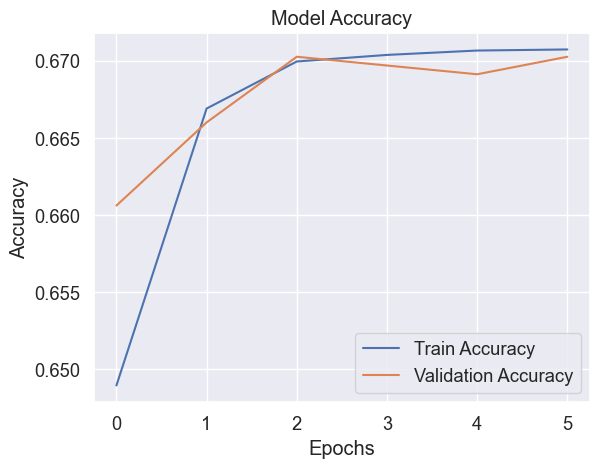

In [46]:
hist = model.history.history
plt.plot(hist['accuracy'], label="Train Accuracy")
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

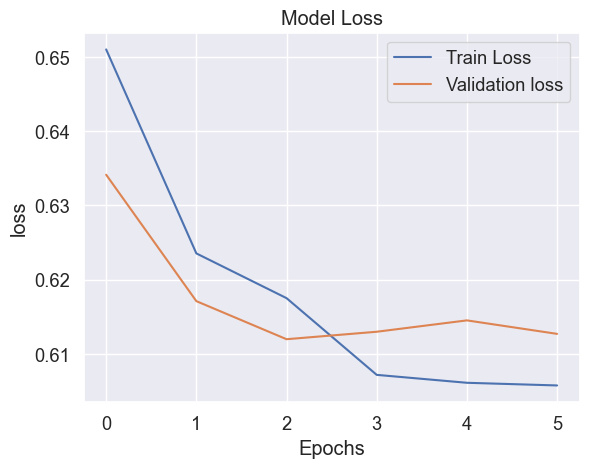

In [47]:
plt.plot(hist['loss'], label="Train Loss")
plt.plot(hist['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [48]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

pd.DataFrame(y_pred[:10], columns=['Prediction'])

138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


,Prediction
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,1
8,0
9,0


In [49]:
spam = 0
ham = 0
for i in y_pred:
  if i == 1:
    spam += 1
  else:
    ham += 1
print(f"length of possible prediction spam: {spam}")
print(f"length of possible prediction ham: {ham}")

length of possible prediction spam: 99
length of possible prediction ham: 4309


#### Visualizing Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [52]:
cm = confusion_matrix(y_pred, y_test)
print(f"confusion matrix \n {cm}")

confusion matrix 
 [[2855 1447]
 [   7   99]]


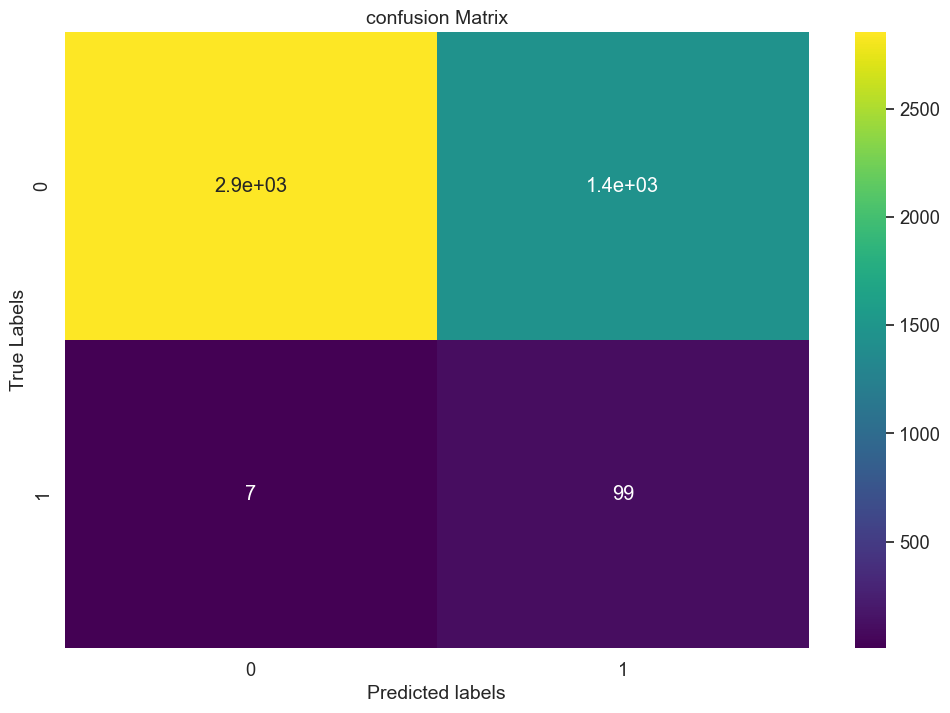

In [53]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cbar=True, cmap="viridis")
plt.title("confusion Matrix", fontsize=14)
plt.xlabel("Predicted labels", fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.show()

In [54]:
print("Classification report \n")
print(classification_report(y_pred, y_test))

Classification report 

              precision    recall  f1-score   support

           0       1.00      0.66      0.80      4302
           1       0.06      0.93      0.12       106

    accuracy                           0.67      4408
   macro avg       0.53      0.80      0.46      4408
weighted avg       0.98      0.67      0.78      4408



#### Single Prediction

In [55]:
input_text =  X_test[8]
print(f"before expanding dims : {input_text, input_text.shape}")
input_text = np.expand_dims(input_text, axis=0)
print(f"after expanding the col dims : {input_text, input_text.shape}")

# make the prediction
prediction = model.predict(input_text)

if prediction[0][0] > 0.5:
  print("Ham")
else:
  print("Spam")

before expanding dims : (array([  115,  1754,     7,     3,  3517,  4453,     7,    18,    16,
         106,   194,    11,     7,     3,     2,     1,  5208,   341,
       13644,     7,    10,   194,   705,    88,    35,  4156, 16754,
        6872,  3541,   626,    51,    34,  1649,   310,   272,    54,
         194,    11,   941,     7,    18,     9,    35,   526,    34,
         187,     7,    10,    16,  3096,   514,     2,     1,    88,
           2,     1,    89,    34,  1649,   160,   272,    54,    34,
        4604,     3,   105,   120,     7,   125,    91,     3,     3,
         745,   235,    91,    35,    54,    11,     7,    76,  2692,
           4,  1207, 20982,   159,    98,    45,   211,    45,     7,
         105,  1232,   120,     7,    76,   221, 20982,   159,   154,
           7,   125,  1207,     3,  1104,    26,     7,   259,   105,
         120,     7,   261,  5021,   514,     4,    10,     3,  3096,
         514,  1802,    45,     2,     1,    88,   600,     9,   

In [56]:
# saving model pkl 
model.save('saved_email_classification.keras')

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten

vocab_size = len(default_tokenizer.word_index) + 1  # 146471
max_length = 500 

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

Epoch 1/10


c:\Users\Asus\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


882/882 ━━━━━━━━━━━━━━━━━━━━ 68s 75ms/step - accuracy: 0.9146 - loss: 0.1885 - val_accuracy: 0.9787 - val_loss: 0.0669
Epoch 2/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step - accuracy: 0.9926 - loss: 0.0226 - val_accuracy: 0.9501 - val_loss: 0.1418
Epoch 3/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step - accuracy: 0.9984 - loss: 0.0059 - val_accuracy: 0.9626 - val_loss: 0.1158
Epoch 4/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 153s 174ms/step - accuracy: 0.9918 - loss: 0.0488 - val_accuracy: 0.9600 - val_loss: 0.1763


#### ANN model evaluating

In [63]:
loss, acc = model.evaluate(X_train, y_train)
print(f'loss of training is {loss:.2f}')
print(f"accuracy of training is {acc:.2f}")

551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9805 - loss: 0.0650
loss of training is 0.07
accuracy of training is 0.98


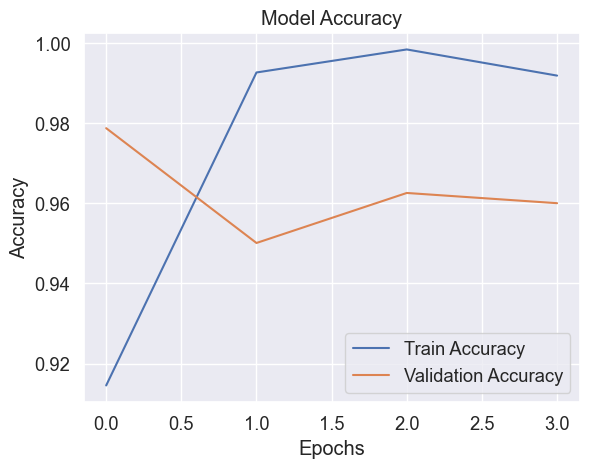

In [64]:
hist = history.history
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

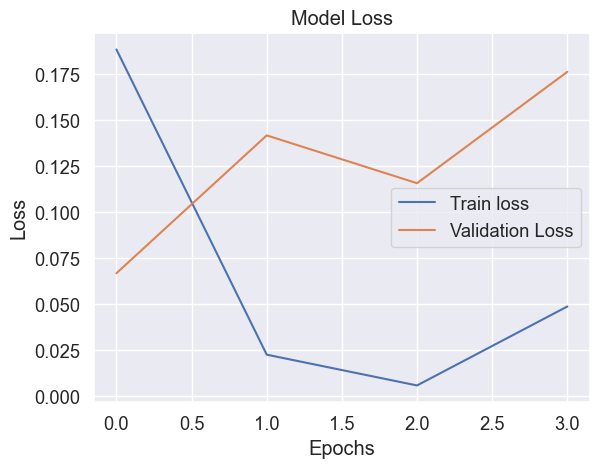

In [65]:
plt.plot(hist['loss'], label='Train loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [66]:
y_pred_ann = model.predict(X_test)
y_pred = (y_pred_ann > 0.5).astype(int) 
pd.DataFrame(y_pred[:10])

138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,0
0,0
1,0
2,0
3,0
4,1
5,1
6,1
7,1
8,1
9,0


In [69]:
from sklearn.metrics import confusion_matrix

In [70]:
cm = confusion_matrix(y_pred, y_test)
print(f"confusion matrix \n {cm}")      

confusion matrix 
 [[2673   26]
 [ 183 1526]]


Text(113.24999999999999, 0.5, 'True labels')

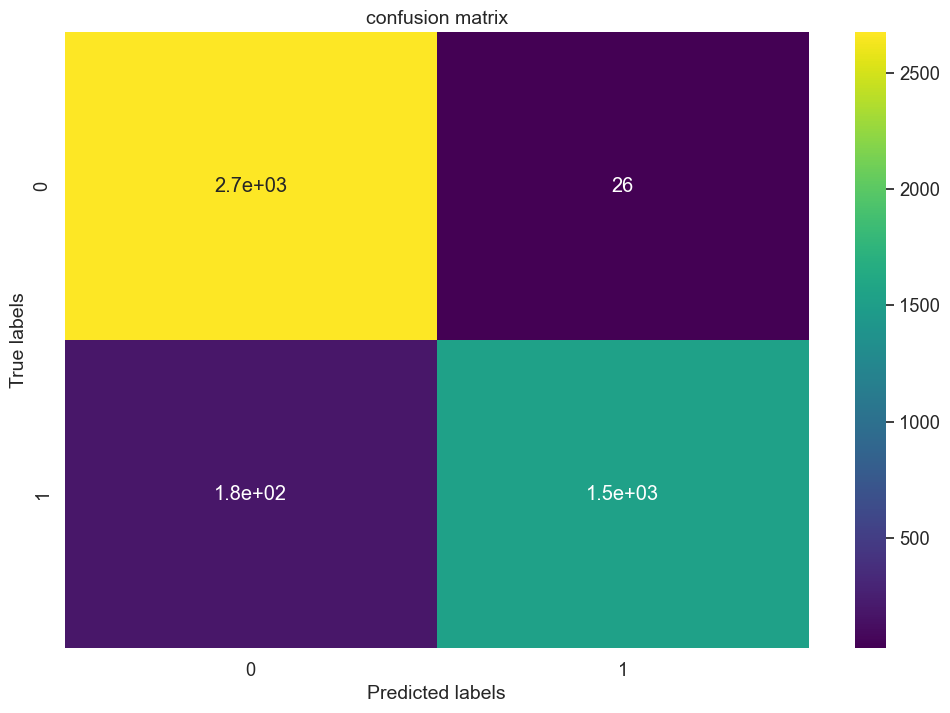

In [71]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cbar=True, cmap='viridis')
plt.title('confusion matrix', fontsize=14)
plt.xlabel("Predicted labels", fontsize=14)
plt.ylabel("True labels", fontsize=14)


In [81]:
text = """
Subject: 🎉 CONGRATULATIONS! You've Won $1,000,000! 🎉
From: winner-notification@lottery-international.biz
Body:
DEAR LUCKY WINNER!!!
CONGRATULATIONS! You have been selected as the GRAND PRIZE WINNER of our International Email Lottery! Your email address was randomly selected from millions of addresses worldwide.
YOU HAVE WON: $1,000,000 USD!!!
To claim your prize, you MUST respond within 24 HOURS with the following information:

Full Name
Address
Phone Number
Bank Account Details
Copy of ID/Passport

URGENT: Send processing fee of $500 via Western Union to claim your winnings immediately!
Contact our claims agent: Mr. Johnson Smith
Email: claims.agent.smith@totally-legit-lottery.com
Phone: +234-555-7845
This offer expires TOMORROW! Don't miss this once-in-a-lifetime opportunity!
Best Regards,
International Lottery Commission
"""

preprocessing_text = text_preprocessing(text)
print(preprocessing_text)
sequences = default_tokenizer.texts_to_sequences([preprocessing_text])
print(sequences)
padding = pad_sequences(sequences, maxlen=sent_length, padding='post')
print(padding)
padding.shape

subject 🎉 congratulation 've  NUM_TOKEN , NUM_TOKEN , NUM_TOKEN  🎉 winner-notification lottery-international.biz body dear lucky winner congratulation select grand prize winner international email lottery email address randomly select million address worldwide  NUM_TOKEN , NUM_TOKEN , NUM_TOKEN  usd claim prize must respond within  NUM_TOKEN  hour follow information full name address phone number bank account detail copy id/passport urgent send process fee  NUM_TOKEN  via western union claim winning immediately contact claim agent mr. johnson smith email claims.agent.smith totally-legit-lottery.com phone + PHONE_TOKEN  offer expire tomorrow n't miss once-in-a-lifetime opportunity best regard international lottery commission
[[5, 41399, 2362, 613, 2, 1, 2, 1, 2, 1, 41399, 1830, 924, 1962, 158, 2051, 885, 686, 2182, 1830, 2362, 511, 2251, 1579, 1830, 158, 25, 1962, 25, 28, 4798, 511, 138, 28, 1390, 2, 1, 2, 1, 2, 1, 1139, 405, 1579, 139, 805, 127, 2, 1, 203, 120, 18, 233, 46, 28, 103, 4,

(1, 500)

In [82]:
single_pred = model.predict(padding)
print(single_pred > 0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[ True]]
